In [ ]:
#!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia
#!unzip chest-xray-covid19-pneumonia.zip

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import PrecisionAtRecall,Recall

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from numpy.random import seed
seed(0)
tf.random.set_seed(0)

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Data"



Mounted at /content/drive
base_model.h5		       train
densenet-100_sample.h5	       unique_20_sample_test
densenet_2_dropout.h5	       unique_20_sample_train
densenet_img_aug.h5	       unique_5_sample_test
model2.h5		       unique_5_sample_train
model_cnn_noaug_70%.h5	       unique_60_sample_test
model_weights_densenet_85%.h5  unique_60_sample_train
resnet_dropout_model1.h5       vgg_1dropout.h5
resnet_dropout_model2.h5       vgg_3dropout.h5
resnet_samplesize_model1.h5    vizgradcam
resnet_samplesize_model3.h5    xception_main1.h5
resnet_withaug_model2_.h5      xception_main.h5
test


In [11]:
train_path = "/content/drive/My Drive/Data/train"
test_path = "/content/drive/My Drive/Data/test"

In [12]:
path = train_path
diag_code_dict = {
    'COVID19': 0,
    'NORMAL': 1,
    'PNEUMONIA': 2}

diag_title_dict = {
    'COVID19': 'Covid-19',
    'NORMAL': 'Healthy',
    'PNEUMONIA': 'Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

imageid_path_dict

{}

## Densenet (1 dropout)

In [10]:


classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)



train_datagen = ImageDataGenerator(
  rescale = 1./224, # standardization
  validation_split=0.001
)

test_datagen = ImageDataGenerator(rescale=1./224,
                                 validation_split=0.999)

train_gen = train_datagen.flow_from_directory(directory=train_path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True, classes=classes,
                                             batch_size=8,
                                             color_mode="rgb")

test_gen = test_datagen.flow_from_directory(directory=test_path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=False, classes=classes,
                                             batch_size=1,
                                             color_mode="rgb")

Found 6028 images belonging to 3 classes.
Found 1285 images belonging to 3 classes.


In [7]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_path, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [9]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(256, activation="relu")(x)
x = Dropout(0.60)(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)




predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_1dropout.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

r = model.fit(
    train_gen, 
    epochs=10,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
  6/100 [>.............................] - ETA: 5:31 - loss: 0.3904 - accuracy: 0.5417

KeyboardInterrupt: ignored

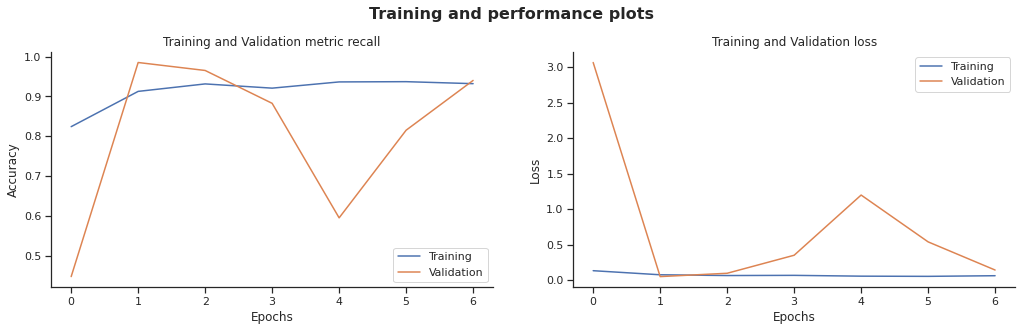

In [ ]:
y_pred = model.predict(test_gen)
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

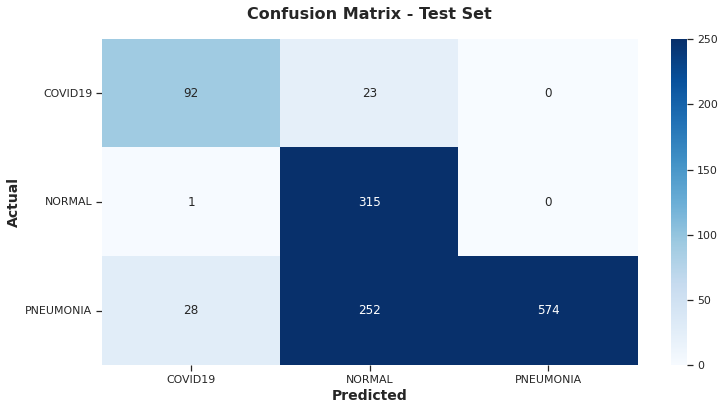

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 38s 460ms/step - loss: 0.6827 - accuracy: 0.7634


[0.6827254295349121, 0.7634240984916687]

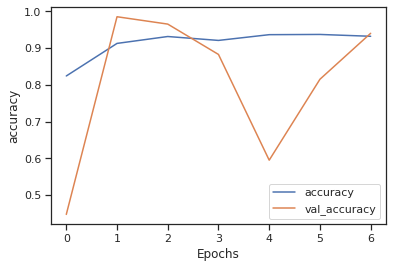

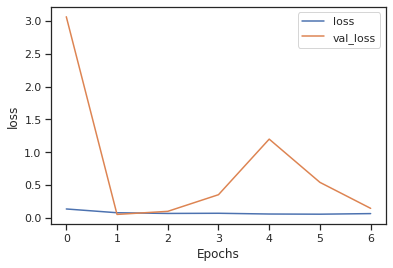

In [ ]:
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

## densenet no drop


In [ ]:


classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)



img_size = [224, 224]
train_datagen = ImageDataGenerator(rescale = 1./224)

test_datagen = ImageDataGenerator(rescale = 1./224)

train_gen = train_datagen.flow_from_directory(directory = train_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 8,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_gen = test_datagen.flow_from_directory(directory = test_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 1,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)



predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_0dropout.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

r = model.fit(
    train_gen, 
    epochs=10,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 96s 824ms/step - loss: 0.1061 - accuracy: 0.8637 - val_loss: 2.8609 - val_accuracy: 0.7200

Epoch 00001: val_loss improved from inf to 2.86089, saving model to densenet_0dropout.h5
Epoch 2/10
100/100 [==============================] - 78s 776ms/step - loss: 0.0765 - accuracy: 0.9062 - val_loss: 4.3471 - val_accuracy: 0.2075

Epoch 00002: val_loss did not improve from 2.86089
Epoch 3/10
100/100 [==============================] - 77s 771ms/step - loss: 0.0608 - accuracy: 0.9294 - val_loss: 0.1591 - val_accuracy: 0.9475

Epoch 00003: val_loss improved from 2.86089 to 0.15908, saving model to densenet_0dropout.h5
Epoch 4/10
100/100 [==============================] - 78s 781ms/step - loss: 0.0639 - accuracy: 0.9174 - val_loss: 3.1163 - val_accuracy: 0.7100

Epoch 00004: val_loss did not improve from 0.15908
Epoch 5/10
100/100 [==============================] - 78s 777ms/step - loss: 0.0622 - accuracy: 0.9219 - val_loss: 1.1873 - val_accu

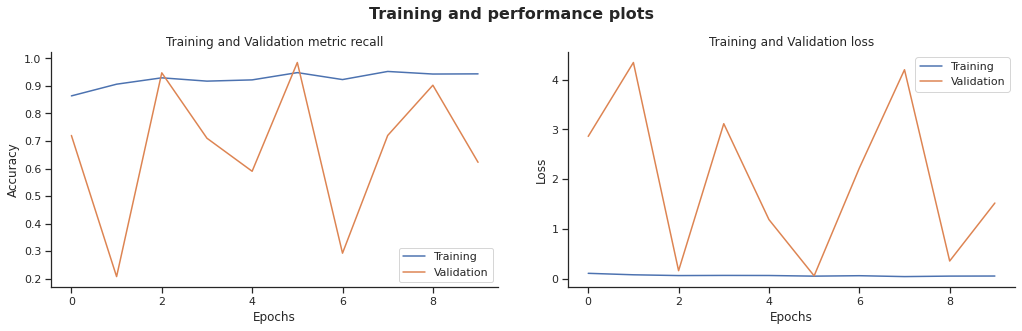

In [ ]:
y_pred = model.predict(test_gen)
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

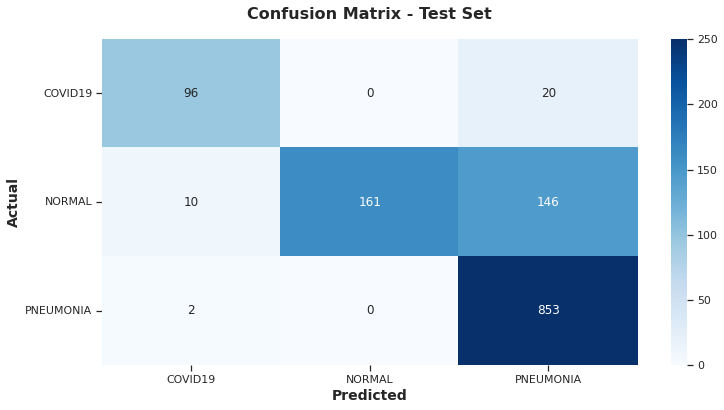

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 38s 466ms/step - loss: 0.5879 - accuracy: 0.8618


[0.5878607034683228, 0.861801266670227]

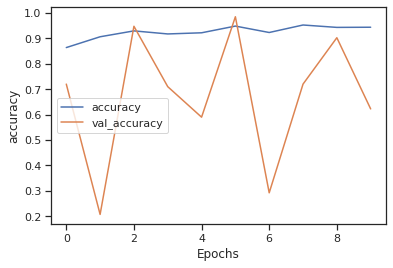

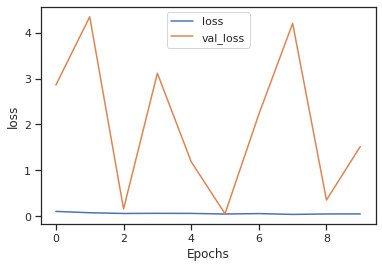

In [ ]:
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

## ***IGNORE***

Model 1 - CNN +  Multi-Layer NN (70%)
> 5 Dropout Layers, Rate = 0.25


In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same', input_shape=(224, 224, 1)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))


model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

 
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

#Print Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 299, 299, 32)      320       
_________________________________________________________________
batch_normalization_18 (Batc (None, 299, 299, 32)      128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 299, 299, 64)      18496     
_________________________________________________________________
batch_normalization_19 (Batc (None, 299, 299, 64)      256       
_________________________________________________________________
average_pooling2d_8 (Average (None, 149, 149, 64)      0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 149, 149, 64)     

In [ ]:
opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs=10

#callback

history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen) // batch_size,
                    validation_steps=len(test_gen) // batch_size,
                    validation_data=test_gen, epochs=epochs,
                    callbacks=[ # This model will be saved as model.h5 and select the best accuracy rate for val_acc. 
      ModelCheckpoint('model_noaug.h5', monitor='acc', verbose=1, save_best_only=True)]
                    )

Epoch 1/20
23/23 [==============================] - 40s 2s/step - loss: 0.7771 - acc: 0.7582 - val_loss: 0.6583 - val_acc: 0.9250

Epoch 00001: acc improved from -inf to 0.75815, saving model to model_noaug.h5
Epoch 2/20
23/23 [==============================] - 42s 2s/step - loss: 0.4008 - acc: 0.8614 - val_loss: 0.3658 - val_acc: 1.0000

Epoch 00002: acc improved from 0.75815 to 0.86141, saving model to model_noaug.h5
Epoch 3/20
23/23 [==============================] - 41s 2s/step - loss: 0.3541 - acc: 0.8696 - val_loss: 0.1281 - val_acc: 1.0000

Epoch 00003: acc improved from 0.86141 to 0.86957, saving model to model_noaug.h5
Epoch 4/20
23/23 [==============================] - 47s 2s/step - loss: 0.2597 - acc: 0.8995 - val_loss: 0.0612 - val_acc: 1.0000

Epoch 00004: acc improved from 0.86957 to 0.89946, saving model to model_noaug.h5
Epoch 5/20
23/23 [==============================] - 39s 2s/step - loss: 0.2759 - acc: 0.9022 - val_loss: 0.0142 - val_acc: 1.0000

Epoch 00005: acc imp

In [ ]:
y_pred = model.predict(test_gen)

In [ ]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

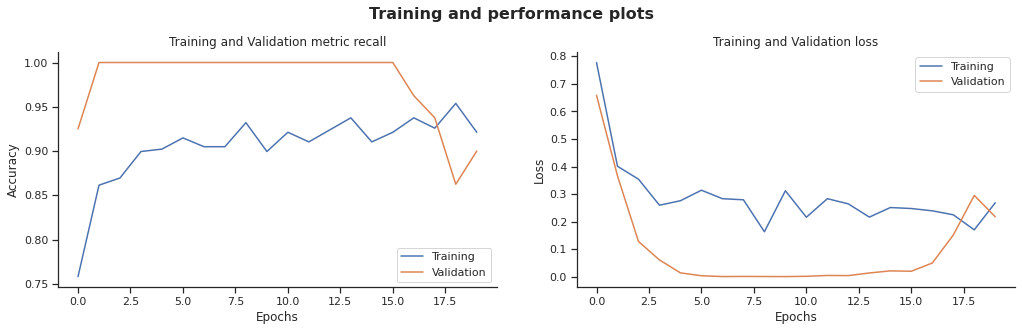

In [ ]:
#y_pred = model.predict(test_gen)
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['acc'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_acc'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

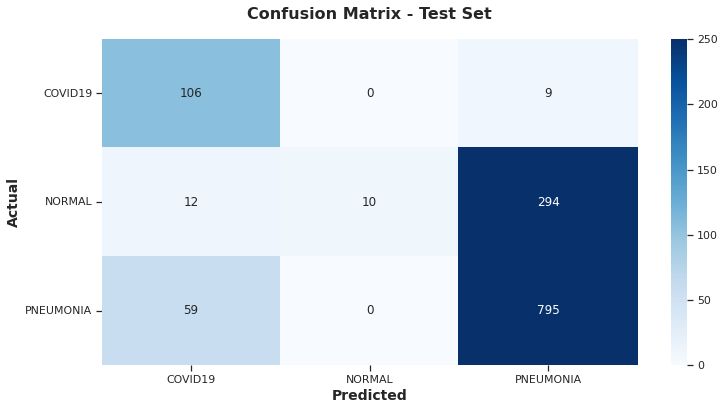

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.60      0.92      0.73       115
           1       1.00      0.03      0.06       316
           2       0.72      0.93      0.81       854

    accuracy                           0.71      1285
   macro avg       0.77      0.63      0.53      1285
weighted avg       0.78      0.71      0.62      1285



In [ ]:
from google.colab import files
files.download('model_noaug.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(model.evaluate(train_gen))
print(model.evaluate(test_gen))

377/377 [==============================] - 298s 787ms/step - loss: 0.7398 - acc: 0.7571
[0.7398234605789185, 0.7571333646774292]
81/81 [==============================] - 39s 471ms/step - loss: 0.8759 - acc: 0.7089
[0.8758559226989746, 0.7089493870735168]


In [ ]:
y_pred

array([[0.3385716 , 0.01054911, 0.6508793 ],
       [0.63165134, 0.02982626, 0.33852237],
       [0.9781034 , 0.01845915, 0.00343746],
       ...,
       [0.01880502, 0.01251732, 0.96867764],
       [0.39991507, 0.10893299, 0.49115193],
       [0.02982428, 0.02024821, 0.94992757]], dtype=float32)

Model 1 CNN & Multi Layer NN (67%, more overfitting occurred)
> 2 Dropout Layers, Rate = 0.25 

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same', input_shape=(224, 224, 1)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=2, strides=2))


model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=2, strides=2))



model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=2, strides=2))


model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

 
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

#Print Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 299, 299, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 299, 299, 64)      256       
_________________________________________________________________
average_pooling2d (AveragePo (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 149, 149, 64)      2

In [ ]:
opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
epochs=20

#callback

history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen) // batch_size,
                    validation_steps=len(test_gen) // batch_size,
                    validation_data=test_gen, epochs=epochs,
                    callbacks=[ # This model will be saved as model.h5 and select the best accuracy rate for val_acc. 
      ModelCheckpoint('model_noaug_2.h5', monitor='acc', verbose=1, save_best_only=True)]
                    )

Epoch 1/20
23/23 [==============================] - 134s 4s/step - loss: 0.6192 - acc: 0.7636 - val_loss: 0.2614 - val_acc: 0.9500

Epoch 00001: acc improved from -inf to 0.76359, saving model to model_noaug_2.h5
Epoch 2/20
23/23 [==============================] - 76s 3s/step - loss: 0.4721 - acc: 0.8451 - val_loss: 0.0235 - val_acc: 1.0000

Epoch 00002: acc improved from 0.76359 to 0.84511, saving model to model_noaug_2.h5
Epoch 3/20
23/23 [==============================] - 72s 3s/step - loss: 0.3136 - acc: 0.8750 - val_loss: 0.0453 - val_acc: 1.0000

Epoch 00003: acc improved from 0.84511 to 0.87500, saving model to model_noaug_2.h5
Epoch 4/20
23/23 [==============================] - 67s 3s/step - loss: 0.3912 - acc: 0.8832 - val_loss: 0.0540 - val_acc: 1.0000

Epoch 00004: acc improved from 0.87500 to 0.88315, saving model to model_noaug_2.h5
Epoch 5/20
23/23 [==============================] - 65s 3s/step - loss: 0.3156 - acc: 0.8832 - val_loss: 0.0290 - val_acc: 1.0000

Epoch 00005

In [ ]:
y_pred = model.predict(test_gen)
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

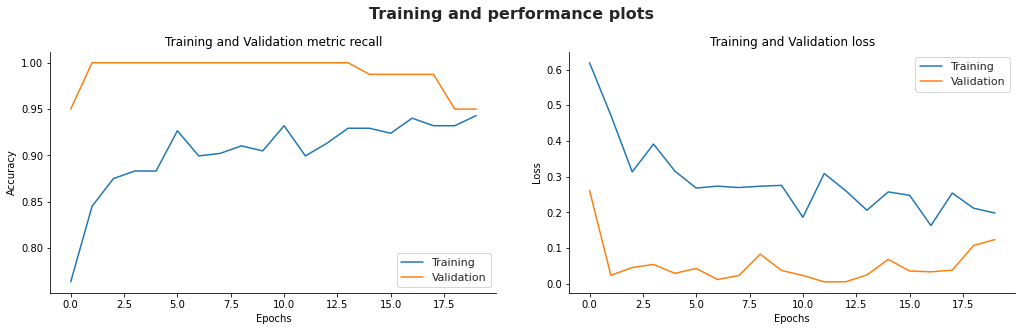

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['acc'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_acc'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

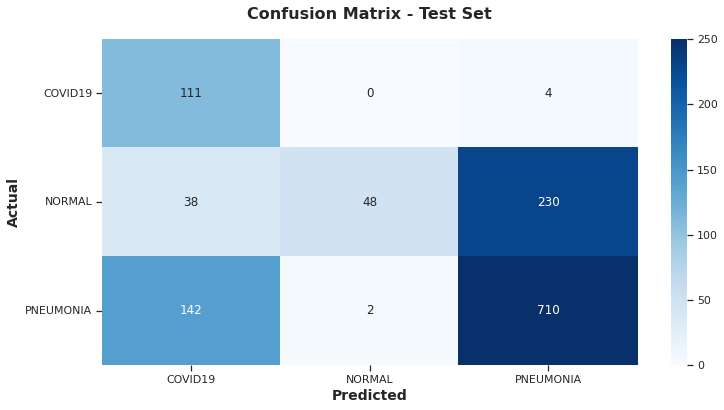

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
print(model.evaluate(train_gen))
print(model.evaluate(test_gen))

377/377 [==============================] - 451s 1s/step - loss: 0.7277 - acc: 0.7473
[0.7276740074157715, 0.7473457455635071]
81/81 [==============================] - 39s 468ms/step - loss: 0.9583 - acc: 0.6763
[0.95833820104599, 0.6762645840644836]


## Densenet (2 dropout) 


In [ ]:


classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)
batch_size = 16


train_datagen = ImageDataGenerator(
  rescale = 1./224, # standardization
  validation_split=0.001
)

test_datagen = ImageDataGenerator(rescale=1./224,
                                 validation_split=0.999)

train_gen = train_datagen.flow_from_directory(directory=train_path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="rgb")

test_gen = test_datagen.flow_from_directory(directory=test_path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=False, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="rgb")

Found 6028 images belonging to 3 classes.
Found 1285 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_path, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.25)(x)

predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_2dropout.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

r = model.fit(
    train_gen, 
    epochs=10,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 97s 817ms/step - loss: 0.1352 - accuracy: 0.8213 - val_loss: 6.4947 - val_accuracy: 0.4550

Epoch 00001: val_loss improved from inf to 6.49475, saving model to densenet_2dropout.h5
Epoch 2/10
100/100 [==============================] - 76s 763ms/step - loss: 0.0842 - accuracy: 0.8913 - val_loss: 0.6247 - val_accuracy: 0.8650

Epoch 00002: val_loss improved from 6.49475 to 0.62470, saving model to densenet_2dropout.h5
Epoch 3/10
100/100 [==============================] - 78s 776ms/step - loss: 0.0769 - accuracy: 0.9094 - val_loss: 1.2356 - val_accuracy: 0.6425

Epoch 00003: val_loss did not improve from 0.62470
Epoch 4/10
100/100 [==============================] - 77s 769ms/step - loss: 0.0643 - accuracy: 0.9156 - val_loss: 0.4460 - val_accuracy: 0.8850

Epoch 00004: val_loss improved from 0.62470 to 0.44595, saving model to densenet_2dropout.h5
Epoch 5/10
100/100 [==============================] - 77s 766ms/step - loss: 0.0682 - accu

In [ ]:
y_pred = model.predict(test_gen)

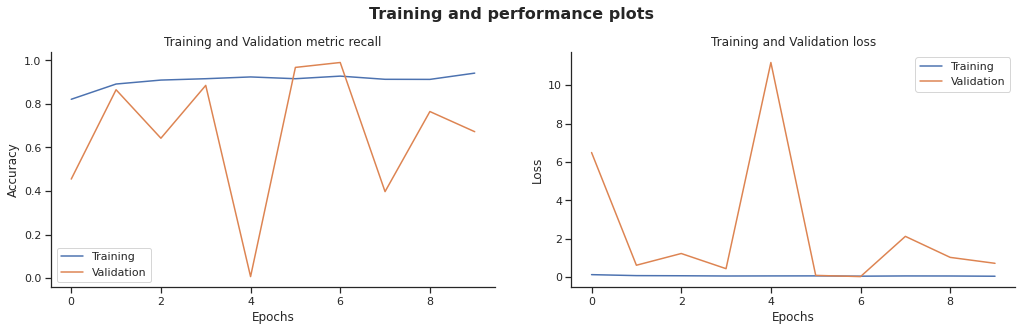

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

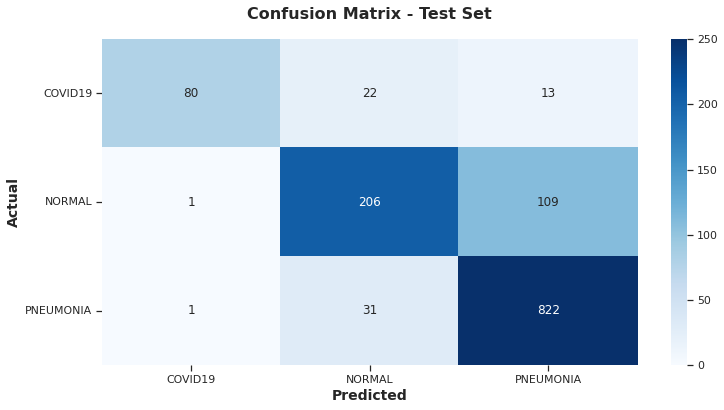

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 38s 465ms/step - loss: 0.3243 - accuracy: 0.8623


[0.3243342339992523, 0.8622568249702454]

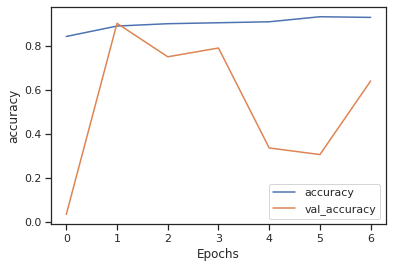

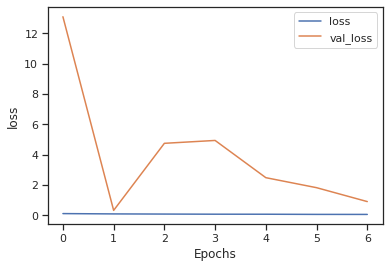

In [ ]:
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

## Model 2 - DenseNet (92%) Base model
no dropout + no extra multi NN layers

In [ ]:


classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)
batch_size = 16


train_datagen = ImageDataGenerator(
  rescale = 1./224, # standardization
  validation_split=0.001
)

test_datagen = ImageDataGenerator(rescale=1./224,
                                 validation_split=0.999)

train_gen = train_datagen.flow_from_directory(directory=train_path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="rgb")

test_gen = test_datagen.flow_from_directory(directory=test_path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=False, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="rgb")

Found 6028 images belonging to 3 classes.
Found 1285 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_path, 'COVID19')))

total = num_normal + num_pneumonia + num_covid

In [ ]:
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

r = model.fit(
    train_gen, 
    epochs=10,
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/10
100/100 [==============================] - 652s 6s/step - loss: 0.1130 - accuracy: 0.8725 - val_loss: 1.1075 - val_accuracy: 0.6925
Epoch 2/10
100/100 [==============================] - 387s 4s/step - loss: 0.0747 - accuracy: 0.9044 - val_loss: 0.9797 - val_accuracy: 0.7275
Epoch 3/10
100/100 [==============================] - 285s 3s/step - loss: 0.0636 - accuracy: 0.9219 - val_loss: 0.4376 - val_accuracy: 0.8050
Epoch 4/10
100/100 [==============================] - 229s 2s/step - loss: 0.0532 - accuracy: 0.9369 - val_loss: 3.7462 - val_accuracy: 0.2800
Epoch 5/10
100/100 [==============================] - 190s 2s/step - loss: 0.0421 - accuracy: 0.9538 - val_loss: 0.0296 - val_accuracy: 0.9925
Epoch 6/10
100/100 [==============================] - 158s 2s/step - loss: 0.0389 - accuracy: 0.9513 - val_loss: 2.4649 - val_accuracy: 0.3875
Epoch 7/10
100/100 [==============================] - 140s 1s/step - loss: 0.

In [ ]:
y_pred = model.predict(test_gen)

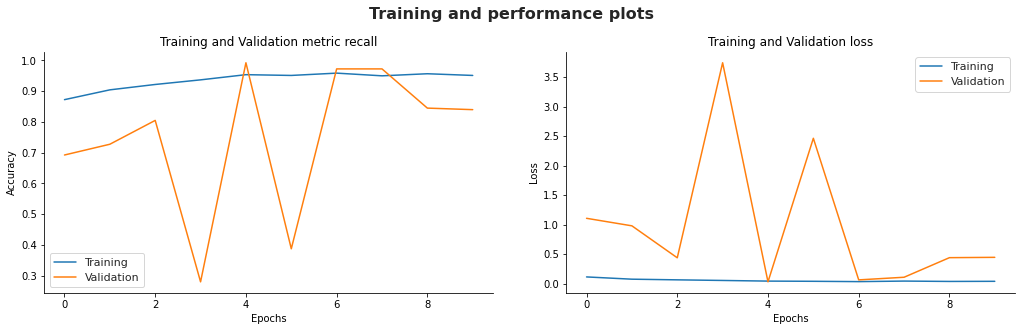

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

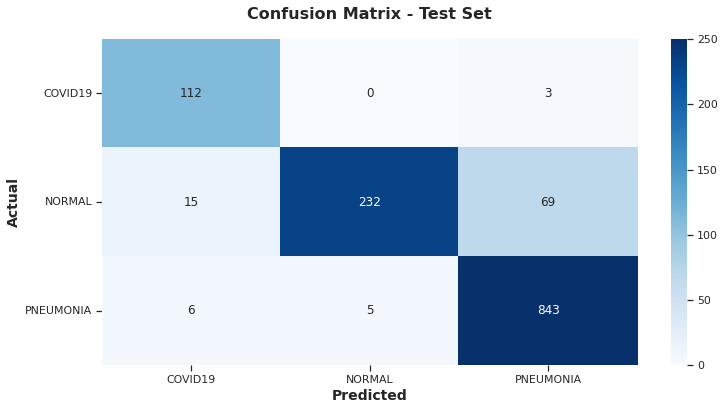

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)

377/377 [==============================] - 245s 649ms/step - loss: 0.2276 - accuracy: 0.9257


[0.22757405042648315, 0.9256801605224609]

In [ ]:
model.evaluate(test_gen)

81/81 [==============================] - 40s 481ms/step - loss: 0.2479 - accuracy: 0.9237


[0.24792292714118958, 0.9237353801727295]

In [ ]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       115
           1       0.98      0.73      0.84       316
           2       0.92      0.99      0.95       854

    accuracy                           0.92      1285
   macro avg       0.91      0.90      0.90      1285
weighted avg       0.93      0.92      0.92      1285



In [ ]:
model.save("model.h5")

In [ ]:
model.save("model.h5")
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model 2 DenseNet (55%)
> Add 2 Dropout Layers (0.25)

In [ ]:


classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)
batch_size = 16


train_datagen = ImageDataGenerator(
  rescale = 1./224, # standardization
  validation_split=0.001
)

test_datagen = ImageDataGenerator(rescale=1./224,
                                 validation_split=0.999)

train_gen = train_datagen.flow_from_directory(directory=train_path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="rgb")

test_gen = test_datagen.flow_from_directory(directory=test_path,
                                             target_size=(299, 299),
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=False, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="rgb")

Found 4996 images belonging to 3 classes.
Found 1285 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_path, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)

predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

r = model.fit(
    train_gen, 
    epochs=10,
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 115s 908ms/step - loss: 0.1245 - accuracy: 0.8444 - val_loss: 74.3999 - val_accuracy: 0.7125
Epoch 2/10
100/100 [==============================] - 88s 875ms/step - loss: 0.0992 - accuracy: 0.8706 - val_loss: 41.9374 - val_accuracy: 0.1975
Epoch 3/10
100/100 [==============================] - 88s 878ms/step - loss: 0.0865 - accuracy: 0.8856 - val_loss: 0.5859 - val_accuracy: 0.7625
Epoch 4/10
100/100 [==============================] - 88s 878ms/step - loss: 0.0732 - accuracy: 0.9081 - val_loss: 0.1256 - val_accuracy: 0.9600
Epoch 5/10
100/100 [==============================] - 95s 945ms/step - loss: 0.0821 - accuracy: 0.9079 - val_loss: 2.1164 - val_accuracy: 0.2975
Epoch 6/10
100/100 [==============================] - 88s 874ms/step - loss: 0.0657 - accuracy: 0.9194 - val_loss: 1.3210 - val_accuracy: 0.4975
Epoch 7/10
100/100 [==============================] - 88s 877ms/step - loss: 0.0672 - accuracy: 0.9198 - val_loss: 0.3397 - val

In [ ]:
y_pred = model.predict(test_gen)

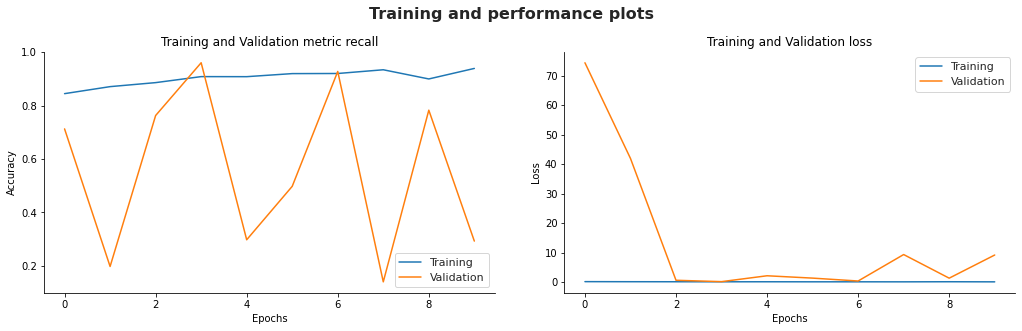

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

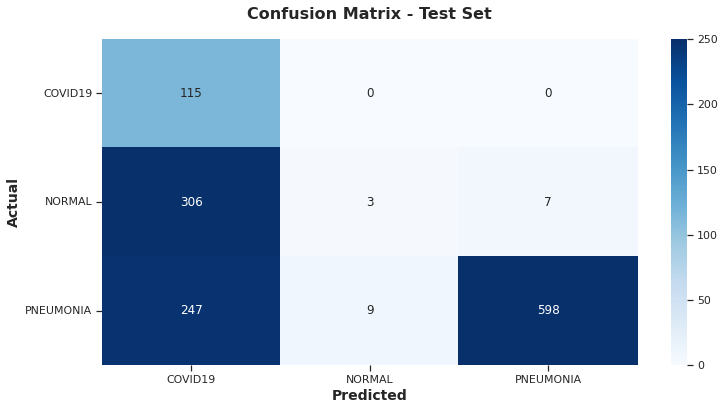

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 39s 468ms/step - loss: 4.0789 - accuracy: 0.5572


[4.07891321182251, 0.5571984648704529]

## Model 2 DenseNet (66%)
> 3 Dropout Layers

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(64, activation="relu")(x)

predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

r = model.fit(
    train_gen, 
    epochs=10,
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/10
100/100 [==============================] - 464s 4s/step - loss: 0.1605 - accuracy: 0.7556 - val_loss: 9.5029 - val_accuracy: 0.7025
Epoch 2/10
100/100 [==============================] - 267s 3s/step - loss: 0.1190 - accuracy: 0.8381 - val_loss: 0.6742 - val_accuracy: 0.8450
Epoch 3/10
100/100 [==============================] - 207s 2s/step - loss: 0.0995 - accuracy: 0.8863 - val_loss: 4.3878 - val_accuracy: 0.7275
Epoch 4/10
100/100 [==============================] - 172s 2s/step - loss: 0.0938 - accuracy: 0.8750 - val_loss: 3.0680 - val_accuracy: 0.2850
Epoch 5/10
100/100 [==============================] - 146s 1s/step - loss: 0.0753 - accuracy: 0.9144 - val_loss: 0.8603 - val_accuracy: 0.7350
Epoch 6/10
100/100 [==============================] - 128s 1s/step - loss: 0.0757 - accuracy: 0.9144 - val_loss: 1.1208 - val_accuracy: 0.5525
Epoch 7/10
100/100 [==============================] - 119s 1s/step - loss: 0.

In [ ]:
y_pred = model.predict(test_gen)

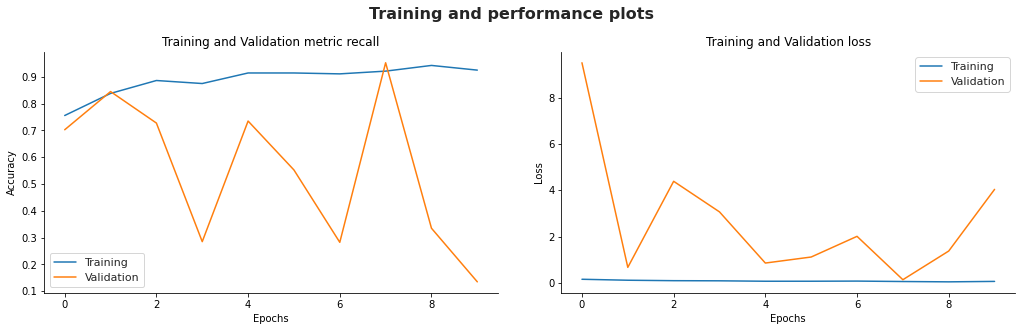

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

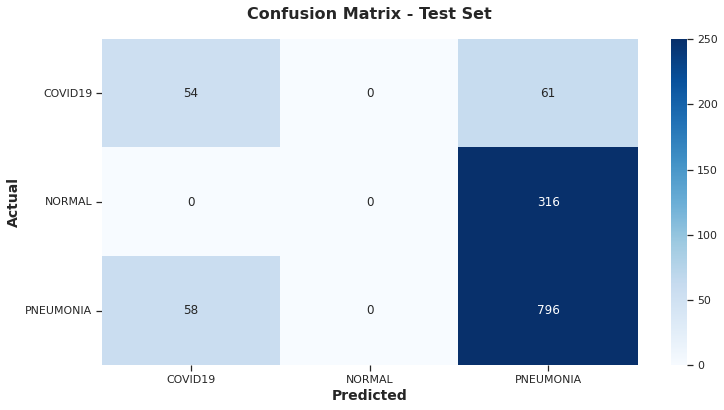

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 39s 471ms/step - loss: 1.5916 - accuracy: 0.6615


[1.5915653705596924, 0.661478579044342]

## Model 2 DenseNet (63%, overfit)
> 1 Dropout Layer

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(64, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(64, activation="relu")(x)

predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

r = model.fit(
    train_gen, 
    epochs=10,
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/10
100/100 [==============================] - 636s 6s/step - loss: 0.1356 - accuracy: 0.8069 - val_loss: 9.0593 - val_accuracy: 0.7125
Epoch 2/10
100/100 [==============================] - 340s 3s/step - loss: 0.0843 - accuracy: 0.8913 - val_loss: 12.8468 - val_accuracy: 0.7125
Epoch 3/10
100/100 [==============================] - 281s 3s/step - loss: 0.0864 - accuracy: 0.8944 - val_loss: 4.9559 - val_accuracy: 0.7025
Epoch 4/10
100/100 [==============================] - 225s 2s/step - loss: 0.0894 - accuracy: 0.8863 - val_loss: 2.2506 - val_accuracy: 0.5250
Epoch 5/10
100/100 [==============================] - 172s 2s/step - loss: 0.0813 - accuracy: 0.8950 - val_loss: 2.2450 - val_accuracy: 0.3600
Epoch 6/10
100/100 [==============================] - 155s 2s/step - loss: 0.0715 - accuracy: 0.9038 - val_loss: 0.2322 - val_accuracy: 0.9075
Epoch 7/10
100/100 [==============================] - 149s 1s/step - loss: 0

In [ ]:
y_pred = model.predict(test_gen)

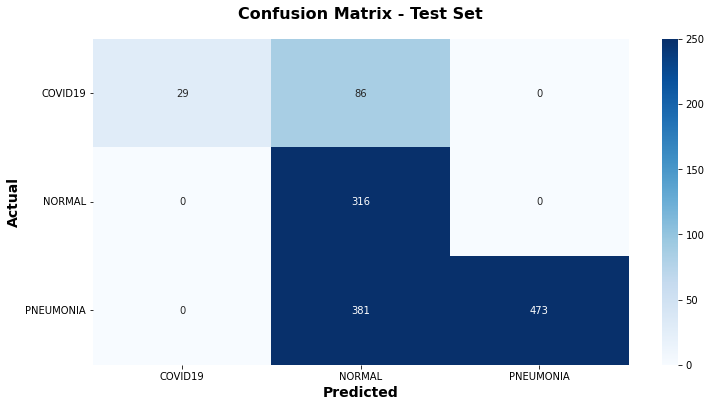

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 39s 478ms/step - loss: 1.7773 - accuracy: 0.6366


[1.7772810459136963, 0.6365758776664734]

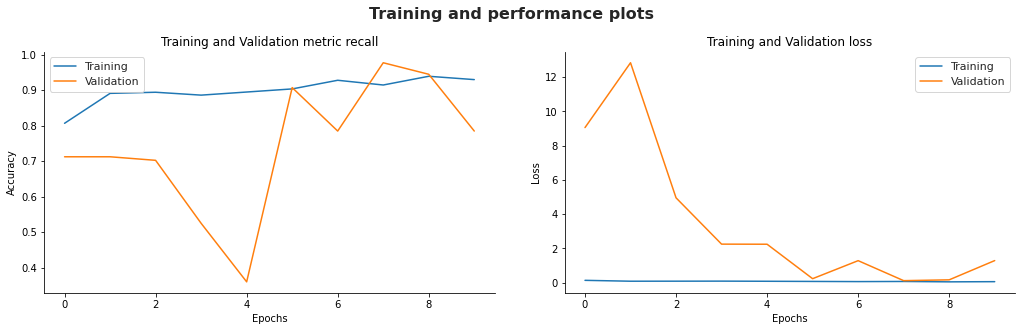

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

## Model 3 - tweak Model 1 (66%)



In [ ]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same', input_shape=(299, 299, 1)))
model.add(BatchNormalization())


model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))


model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.30))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.30))

 
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

#Print Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 299, 299, 64)      640       
_________________________________________________________________
batch_normalization_9 (Batch (None, 299, 299, 64)      256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 299, 299, 64)      36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 299, 299, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 64)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 149, 149, 64)     

In [ ]:
opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
epochs = 10
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen) // batch_size,
                    validation_steps=len(test_gen) // batch_size,
                    validation_data=test_gen, epochs=epochs,
                    callbacks=[ # This model will be saved as model.h5 and select the best accuracy rate for val_acc. 
      ModelCheckpoint('model_cnn_maxpooling.h5', monitor='acc', verbose=1, save_best_only=True)]
                    )

Epoch 1/10
23/23 [==============================] - 46s 2s/step - loss: 0.9358 - acc: 0.6440 - val_loss: 2.2620 - val_acc: 0.0000e+00

Epoch 00001: acc improved from -inf to 0.64402, saving model to model_cnn_maxpooling.h5
Epoch 2/10
23/23 [==============================] - 36s 2s/step - loss: 0.6874 - acc: 0.7473 - val_loss: 2.6285 - val_acc: 0.0000e+00

Epoch 00002: acc improved from 0.64402 to 0.74728, saving model to model_cnn_maxpooling.h5
Epoch 3/10
23/23 [==============================] - 33s 1s/step - loss: 0.5270 - acc: 0.8152 - val_loss: 1.3297 - val_acc: 0.0000e+00

Epoch 00003: acc improved from 0.74728 to 0.81522, saving model to model_cnn_maxpooling.h5
Epoch 4/10
23/23 [==============================] - 36s 2s/step - loss: 0.4982 - acc: 0.8071 - val_loss: 1.3069 - val_acc: 0.0000e+00

Epoch 00004: acc did not improve from 0.81522
Epoch 5/10
23/23 [==============================] - 37s 2s/step - loss: 0.4650 - acc: 0.8505 - val_loss: 1.3186 - val_acc: 0.0000e+00

Epoch 000

In [ ]:
y_pred = model.predict(test_gen)

In [ ]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

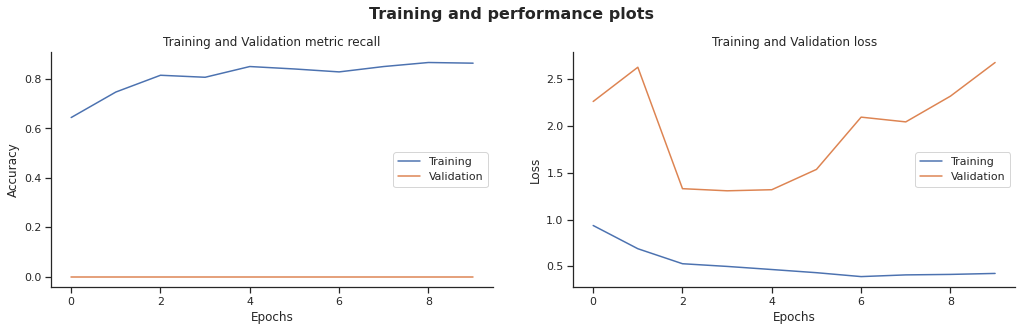

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['acc'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_acc'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

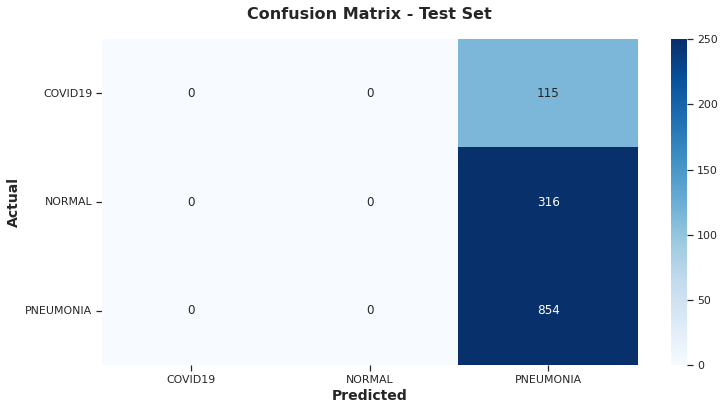

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.00      0.00      0.00       316
           2       0.66      1.00      0.80       854

    accuracy                           0.66      1285
   macro avg       0.22      0.33      0.27      1285
weighted avg       0.44      0.66      0.53      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 4 (66%)

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same', input_shape=(299, 299, 1)))
model.add(BatchNormalization())

################

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))

#################

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))

#################

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output 
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

#Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 299, 299, 32)      320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 299, 299, 32)      128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 299, 299, 64)      18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 299, 299, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 149, 149, 32)     

In [ ]:
opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
epochs=25

#callback

history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen) // batch_size,
                    validation_steps=len(test_gen) // batch_size,
                    validation_data=test_gen, epochs=epochs)

Epoch 1/25
20/20 [==============================] - 20s 796ms/step - loss: 1.0943 - acc: 0.6500 - val_loss: 2.8753 - val_acc: 0.0000e+00
Epoch 2/25
20/20 [==============================] - 15s 750ms/step - loss: 0.5233 - acc: 0.8094 - val_loss: 3.5841 - val_acc: 0.0000e+00
Epoch 3/25
20/20 [==============================] - 15s 780ms/step - loss: 0.4362 - acc: 0.8562 - val_loss: 2.5560 - val_acc: 0.0000e+00
Epoch 4/25
20/20 [==============================] - 16s 819ms/step - loss: 0.4598 - acc: 0.8469 - val_loss: 3.2588 - val_acc: 0.0000e+00
Epoch 5/25
20/20 [==============================] - 16s 797ms/step - loss: 0.3985 - acc: 0.8750 - val_loss: 3.9773 - val_acc: 0.0000e+00
Epoch 6/25
20/20 [==============================] - 15s 768ms/step - loss: 0.3628 - acc: 0.8875 - val_loss: 3.5406 - val_acc: 0.0000e+00
Epoch 7/25
20/20 [==============================] - 15s 744ms/step - loss: 0.3013 - acc: 0.9125 - val_loss: 3.7786 - val_acc: 0.0000e+00
Epoch 8/25
20/20 [=======================

In [ ]:
y_pred = model.predict(test_gen)
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

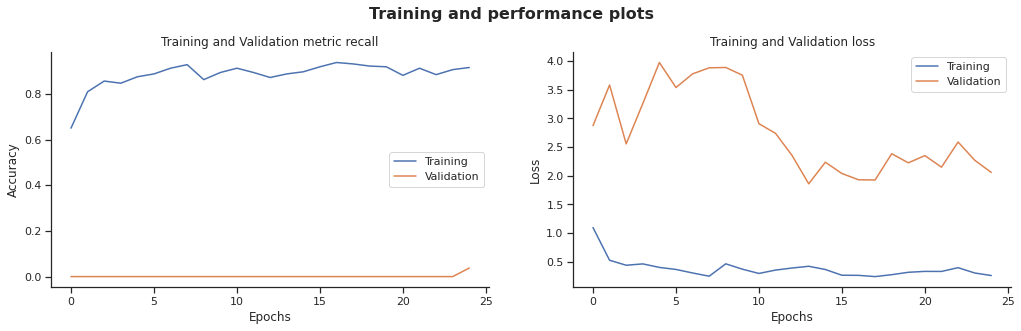

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['acc'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_acc'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

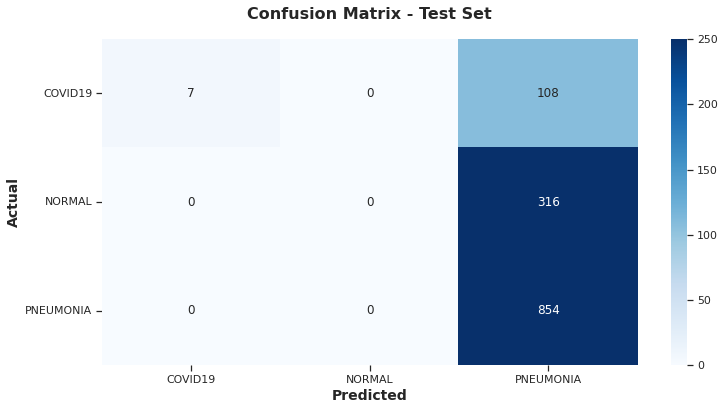

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       1.00      0.06      0.11       115
           1       0.00      0.00      0.00       316
           2       0.67      1.00      0.80       854

    accuracy                           0.67      1285
   macro avg       0.56      0.35      0.31      1285
weighted avg       0.53      0.67      0.54      1285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 5 (76%)

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same', input_shape=(299, 299, 1)))
model.add(BatchNormalization())

################

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=3, strides=3)) # Max Pooling doesn't work as well. 
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=3, strides=3))
model.add(Dropout(0.2))

#################

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=2, strides=2))
model.add(Dropout(0.20))

#################

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output 
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

#Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 299, 299, 32)      320       
_________________________________________________________________
batch_normalization_18 (Batc (None, 299, 299, 32)      128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 299, 299, 64)      18496     
_________________________________________________________________
batch_normalization_19 (Batc (None, 299, 299, 64)      256       
_________________________________________________________________
average_pooling2d (AveragePo (None, 99, 99, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 99, 99, 64)       

In [ ]:
opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
epochs=25

#callback

history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen) // batch_size,
                    validation_steps=len(test_gen) // batch_size,
                    validation_data=test_gen, epochs=epochs)

Epoch 1/25
20/20 [==============================] - 18s 774ms/step - loss: 1.0130 - acc: 0.6156 - val_loss: 0.9234 - val_acc: 0.6500
Epoch 2/25
20/20 [==============================] - 15s 742ms/step - loss: 0.6689 - acc: 0.7531 - val_loss: 0.4610 - val_acc: 0.9500
Epoch 3/25
20/20 [==============================] - 15s 757ms/step - loss: 0.4850 - acc: 0.8375 - val_loss: 0.0805 - val_acc: 1.0000
Epoch 4/25
20/20 [==============================] - 14s 715ms/step - loss: 0.4776 - acc: 0.8625 - val_loss: 0.1615 - val_acc: 1.0000
Epoch 5/25
20/20 [==============================] - 15s 747ms/step - loss: 0.4229 - acc: 0.8625 - val_loss: 0.4101 - val_acc: 0.9875
Epoch 6/25
20/20 [==============================] - 15s 739ms/step - loss: 0.3866 - acc: 0.8562 - val_loss: 0.3934 - val_acc: 0.9875
Epoch 7/25
20/20 [==============================] - 15s 749ms/step - loss: 0.5112 - acc: 0.8438 - val_loss: 0.0265 - val_acc: 1.0000
Epoch 8/25
20/20 [==============================] - 14s 713ms/step - 

In [ ]:
y_pred = model.predict(test_gen)
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

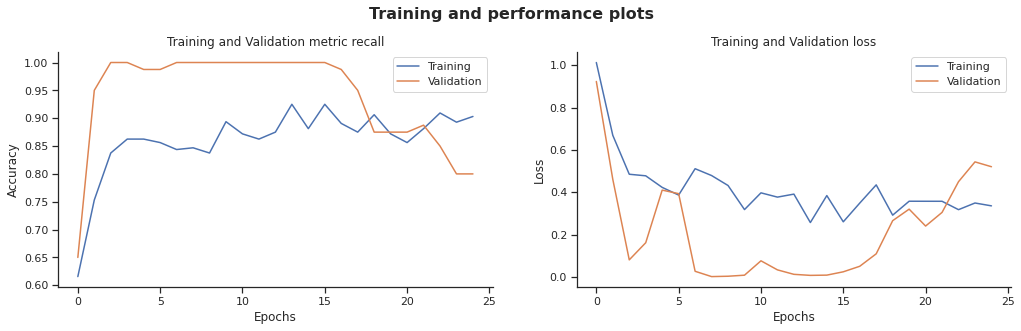

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['acc'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_acc'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

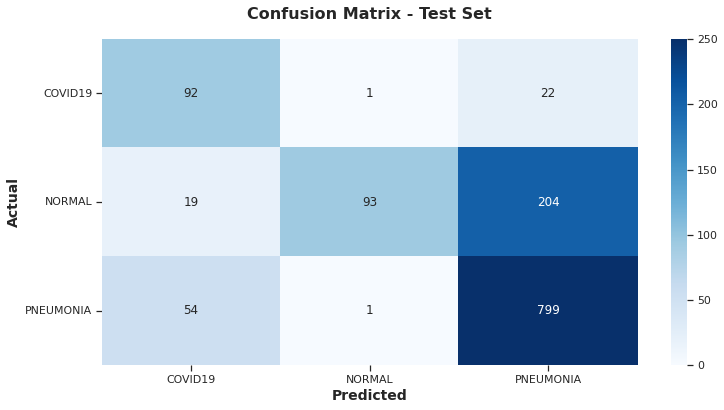

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.56      0.80      0.66       115
           1       0.98      0.29      0.45       316
           2       0.78      0.94      0.85       854

    accuracy                           0.77      1285
   macro avg       0.77      0.68      0.65      1285
weighted avg       0.81      0.77      0.74      1285



## updated densenet - refer to this

## Densenet (2 dropout) 


In [ ]:


classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)
batch_size = 16


train_datagen = ImageDataGenerator(
  rescale = 1./224, # standardization
  validation_split=0.001
)

test_datagen = ImageDataGenerator(rescale=1./224,
                                 validation_split=0.999)

train_gen = train_datagen.flow_from_directory(directory=train_path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="rgb")

test_gen = test_datagen.flow_from_directory(directory=test_path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=False, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="rgb")

Found 6028 images belonging to 3 classes.
Found 1285 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_path, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.25)(x)

predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_2dropout.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

r = model.fit(
    train_gen, 
    epochs=10,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 97s 817ms/step - loss: 0.1352 - accuracy: 0.8213 - val_loss: 6.4947 - val_accuracy: 0.4550

Epoch 00001: val_loss improved from inf to 6.49475, saving model to densenet_2dropout.h5
Epoch 2/10
100/100 [==============================] - 76s 763ms/step - loss: 0.0842 - accuracy: 0.8913 - val_loss: 0.6247 - val_accuracy: 0.8650

Epoch 00002: val_loss improved from 6.49475 to 0.62470, saving model to densenet_2dropout.h5
Epoch 3/10
100/100 [==============================] - 78s 776ms/step - loss: 0.0769 - accuracy: 0.9094 - val_loss: 1.2356 - val_accuracy: 0.6425

Epoch 00003: val_loss did not improve from 0.62470
Epoch 4/10
100/100 [==============================] - 77s 769ms/step - loss: 0.0643 - accuracy: 0.9156 - val_loss: 0.4460 - val_accuracy: 0.8850

Epoch 00004: val_loss improved from 0.62470 to 0.44595, saving model to densenet_2dropout.h5
Epoch 5/10
100/100 [==============================] - 77s 766ms/step - loss: 0.0682 - accu

In [ ]:
y_pred = model.predict(test_gen)

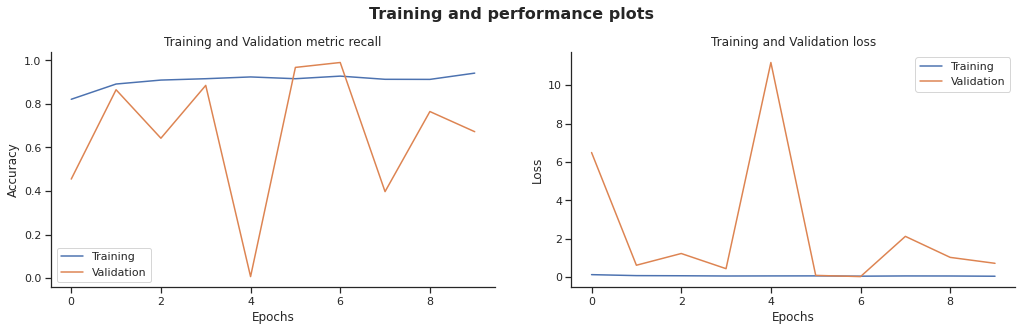

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

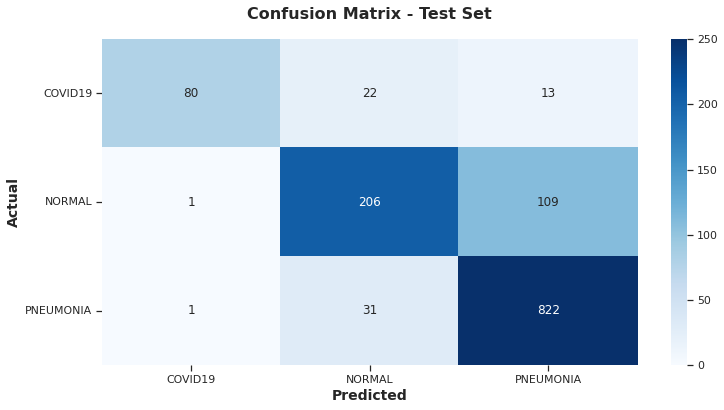

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 38s 465ms/step - loss: 0.3243 - accuracy: 0.8623


[0.3243342339992523, 0.8622568249702454]

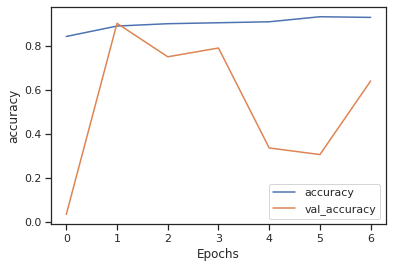

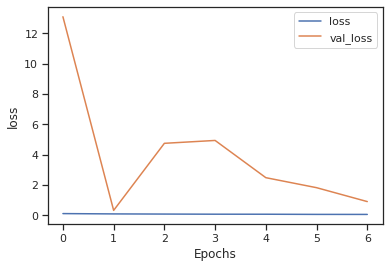

In [ ]:
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

## Densenet (1 dropout)

In [ ]:


classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)
batch_size = 16


train_datagen = ImageDataGenerator(
  rescale = 1./224, # standardization
  validation_split=0.001
)

test_datagen = ImageDataGenerator(rescale=1./224,
                                 validation_split=0.999)

train_gen = train_datagen.flow_from_directory(directory=train_path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="rgb")

test_gen = test_datagen.flow_from_directory(directory=test_path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=False, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="rgb")

Found 6028 images belonging to 3 classes.
Found 1285 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_path, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(64, activation="relu")(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.25)(x)



predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_1dropout.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

r = model.fit(
    train_gen, 
    epochs=10,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 95s 818ms/step - loss: 0.1336 - accuracy: 0.8239 - val_loss: 3.0664 - val_accuracy: 0.4475

Epoch 00001: val_loss improved from inf to 3.06643, saving model to densenet_1dropout.h5
Epoch 2/10
100/100 [==============================] - 76s 755ms/step - loss: 0.0762 - accuracy: 0.9125 - val_loss: 0.0506 - val_accuracy: 0.9850

Epoch 00002: val_loss improved from 3.06643 to 0.05055, saving model to densenet_1dropout.h5
Epoch 3/10
100/100 [==============================] - 76s 764ms/step - loss: 0.0655 - accuracy: 0.9312 - val_loss: 0.0974 - val_accuracy: 0.9650

Epoch 00003: val_loss did not improve from 0.05055
Epoch 4/10
100/100 [==============================] - 77s 774ms/step - loss: 0.0680 - accuracy: 0.9206 - val_loss: 0.3513 - val_accuracy: 0.8825

Epoch 00004: val_loss did not improve from 0.05055
Epoch 5/10
100/100 [==============================] - 77s 768ms/step - loss: 0.0567 - accuracy: 0.9362 - val_loss: 1.1993 - val_accu

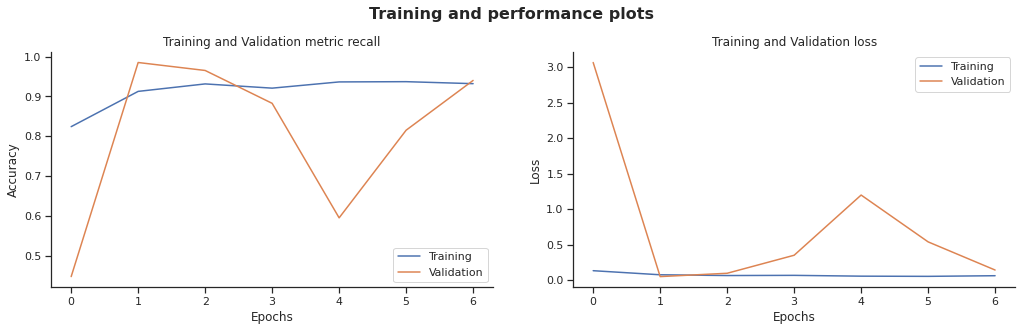

In [ ]:
y_pred = model.predict(test_gen)
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

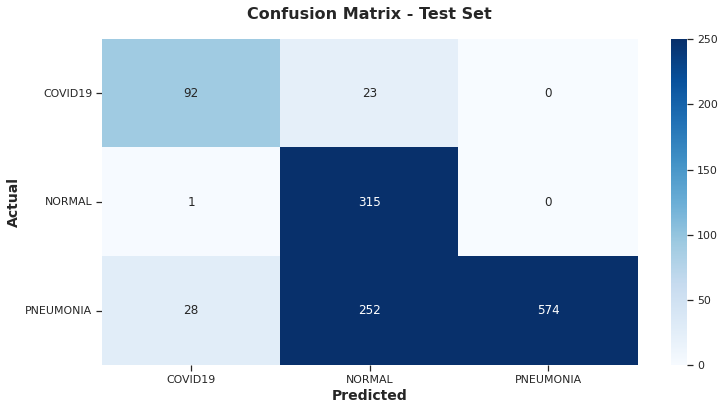

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 38s 460ms/step - loss: 0.6827 - accuracy: 0.7634


[0.6827254295349121, 0.7634240984916687]

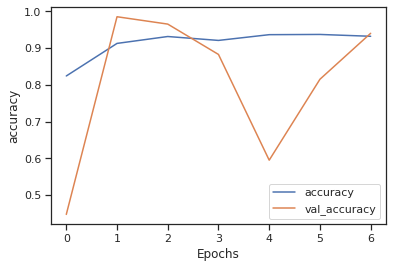

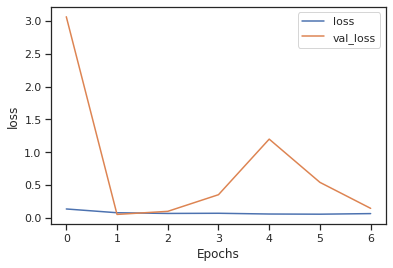

In [ ]:
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

## densenet no drop


In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)



predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_0dropout.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

r = model.fit(
    train_gen, 
    epochs=10,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 96s 806ms/step - loss: 0.1013 - accuracy: 0.8700 - val_loss: 5.1366 - val_accuracy: 0.1425

Epoch 00001: val_loss improved from inf to 5.13658, saving model to densenet_0dropout.h5
Epoch 2/10
100/100 [==============================] - 75s 747ms/step - loss: 0.0795 - accuracy: 0.8950 - val_loss: 0.1981 - val_accuracy: 0.9350

Epoch 00002: val_loss improved from 5.13658 to 0.19808, saving model to densenet_0dropout.h5
Epoch 3/10
100/100 [==============================] - 76s 762ms/step - loss: 0.0676 - accuracy: 0.9150 - val_loss: 0.5869 - val_accuracy: 0.8425

Epoch 00003: val_loss did not improve from 0.19808
Epoch 4/10
100/100 [==============================] - 77s 771ms/step - loss: 0.0498 - accuracy: 0.9348 - val_loss: 0.3024 - val_accuracy: 0.8875

Epoch 00004: val_loss did not improve from 0.19808
Epoch 5/10
100/100 [==============================] - 78s 780ms/step - loss: 0.0545 - accuracy: 0.9311 - val_loss: 0.5848 - val_accu

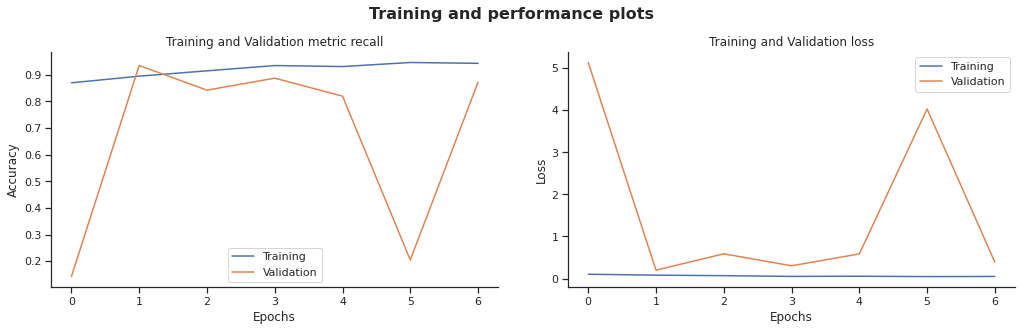

In [ ]:
y_pred = model.predict(test_gen)
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

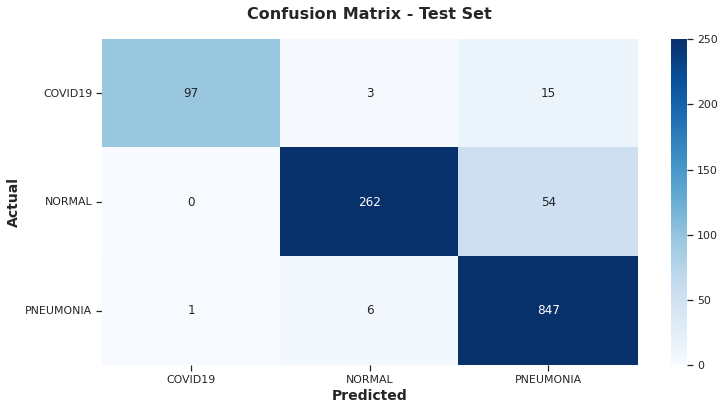

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 38s 463ms/step - loss: 0.1948 - accuracy: 0.9385


[0.19477976858615875, 0.9385213851928711]

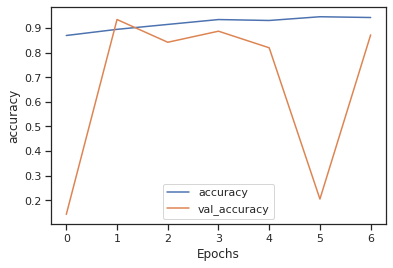

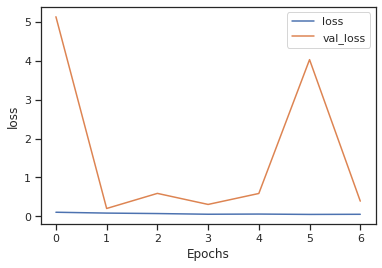

In [ ]:
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
model.save("densenet_0dropout.h5.h5")
from google.colab import files
files.download('densenet_0dropout.h5.h5')

model.save("densenet_1dropout.h5.h5")
from google.colab import files
files.download('densenet_1dropout.h5.h5')

model.save("densenet_1dropout.h5.h5")
from google.colab import files
files.download('densenet_1dropout.h5.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

model.save("densenet_2dropout.h5.h5")
files.download('densenet_2dropout.h5.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>